In [97]:
#%%
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
from scipy.stats import norm
import sqlite3
from datetime import timedelta
import matplotlib.lines as mlines
import multiprocessing
import os

class BSHelper:
    # Calculates rolling volatility based on the 'close' price
    def rolling_volatility(self, data: pd.DataFrame, window: int = 30) -> pd.Series:
        """
        Calculate rolling volatility over a specified window.
        """
        return data['close'].rolling(window=window).std()
    
    def black_scholes(self, St, K, r, T, t, sigma):
        time = (T-t)/252
        d1 = (np.log(St / K) + (r + 0.5 * sigma**2) * time) / (sigma * np.sqrt(time))
        d2 = d1 - sigma * np.sqrt(time)

        calculated_call_price = St * norm.cdf(d1) - K * np.exp(-r * time) * norm.cdf(d2)
        
        return calculated_call_price

    def dc_dsigma(self, St, K, r, T, t, sigma):
        time = (T-t)/252
        dphi_dsigma = np.sqrt(time)/2 - ((np.log(St/K) + r*T)/(sigma**2 * np.sqrt(time)))
        dc_dsigma_val = (St + K*np.exp(-r*T))*dphi_dsigma - K*np.exp(-r*T)*np.sqrt(T)
        return dc_dsigma_val
    
    def newton_rhapson(self, St, K, r, T, t, sigma_est, call_price, tolerance=0.001, suppressLogs=False, max_iterations: int = 1000) -> float:
        sigma = sigma_est


        for i in range(0, max_iterations):
            fx = call_price - self.black_scholes(St, K, r, T, t, sigma)
            dfx = self.dc_dsigma(St, K, r, T, t, sigma)
            
            if abs(dfx) < 1e-12:
                print("Derivative is close to zero, Newton-Raphson may fail.")

            sigma_next = sigma - fx/dfx
            
            if abs(fx) <= tolerance:
                print(f"sigma={sigma}, sigma_next={sigma_next}, i={i}")
                sigma = sigma_next
                
                if not suppressLogs:
                    print(f'found the value at the {i}th iteration')
                
                break
            
            if i == max_iterations-1:
                print(f'cound not find root after {max_iterations} iterations')
            
            sigma = sigma_next

        if not suppressLogs:
            print(f'Implied Volatility: {sigma}, Call Price: {self.black_scholes(St, K, r, T, t, sigma)}')
        
        return sigma
    
    def get_realized_vol(self, dataset, time=21, fill_initial=True):
        dataset['returns'] = np.log(dataset["close"]/dataset["close"].shift(1))
        dataset.fillna(0, inplace=True)
        volatility = dataset.returns.rolling(window=time).std(ddof=0)*np.sqrt(252)
        if fill_initial:
            # Fill the first (time-1) NaN values with the first non-NaN volatility value
            first_valid = volatility[time-1]
            volatility.iloc[:time-1] = first_valid
        return volatility
    
    def get_historical_vol(self, dataset, type, time=21):
        if type == 'parkinson':
            hl_log_sq = (np.log(dataset['high']/dataset['low'])) **2
            factor = 1/(4 * np.log(2))
            
            parkinson_daily_var = hl_log_sq * factor
            rolling_var = parkinson_daily_var.rolling(window=time).mean()
            
            # Annualize
            parkinson_vol = np.sqrt(rolling_var * 252)
            return parkinson_vol
        elif type == 'gk':
            log_hl_sq = (np.log(dataset['high']/dataset['low']))**2
            log_co_sq = (np.log(dataset['close']/dataset['open']))**2
            
            daily_variance = 0.5 * log_hl_sq - (2 * np.log(2) - 1) * log_co_sq
            
            rolling_var = daily_variance.rolling(window = time).mean()
            
            # Annualize
            gk_vol = np.sqrt(rolling_var * 252)
            
            return gk_vol
    
    # Sets NaN values to 0 and categorizes volatility into states
    def qcut_volatility(self, volatility: pd.Series, nStates: int = 3):

        volatility.fillna(0, inplace=True)
        volatility_states = pd.qcut(volatility, q=nStates, labels=range(nStates))
        df_vol_states = pd.DataFrame({
            'volatility': volatility,
            'volatility_state': volatility_states
        })
        df_vol_states['mean_volatility'] = df_vol_states.groupby('volatility_state', observed=False)['volatility'].transform('mean')
        return df_vol_states
    
    # Function to get the holding times and transitions
    def getHoldingTimesAndTransitions(self, df_vol_states: pd.DataFrame):
            
        nStates = df_vol_states['volatility_state'].cat.categories.size
        transitions = np.zeros((nStates, nStates))
        holding_times = np.zeros(nStates)

        for i in range(1, len(df_vol_states['volatility_state'])):
            s_prev = df_vol_states['volatility_state'].iloc[i-1]
            s_curr = df_vol_states['volatility_state'].iloc[i]
            # delta_t = (df.iloc[i]['Date'] - df.iloc[i-1]['Date']).days # 1 day is the delta

            holding_times[s_prev] += 1
            if s_prev != s_curr:
                transitions[s_prev, s_curr] += 1
        
        return (holding_times, transitions)

    # Compute the Q Matrix
    def computeQMatrix(self, holding_times, transitions, df_vol_states: pd.DataFrame):
        nStates = nStates = df_vol_states['volatility_state'].cat.categories.size
        Q = np.zeros((nStates, nStates))

        for i in range(nStates):
            for j in range(nStates):
                if i != j:
                    Q[i, j] = transitions[i, j] / holding_times[i]
            Q[i, i] = -np.sum(Q[i, :])
        
        return Q
    
    def simulate_ctmc(self, Q, vol_state_df: pd.DataFrame, start_state: int, time_horizon: int):
        states = vol_state_df['volatility_state'].cat.categories.tolist()
        current_state = states.index(start_state)
        time = 0
        history = [(time, states[current_state])]

        while time < time_horizon:
            rate = -Q[current_state, current_state]
            time += np.random.exponential(1/rate)

            probs = (Q[current_state]/rate)
            probs[current_state] = 0 # No self-transition

            next_state = np.random.choice(range(len(states)), p=probs)

            current_state = next_state
            history.append((float(np.round(time,2)), states[current_state]))
        
        return history
    
    def _ctmc_worker(self, args):
        q_matrix, vol_state_df, start_state, time_horizon, num = args
        results = []
        for _ in range(num):
            results.append(self.simulate_ctmc(q_matrix, vol_state_df, start_state, time_horizon))
        return results
    
    def simulate_ctmc_parallel(self, q_matrix, vol_state_df: pd.DataFrame, start_state: int, time_horizon: int,
                           num_simulations: int = 1_000_000, num_cores: int = 1):
        chunk_size = num_simulations // num_cores
        args_list = [(q_matrix, vol_state_df, start_state, time_horizon, chunk_size) for _ in range(num_cores)]

        with multiprocessing.get_context("fork").Pool(num_cores) as pool:
            results = pool.map(self._ctmc_worker, args_list)
        return [item for sublist in results for item in sublist]
    
    # Return the unique states and corresponding volatility values
    def get_unique_states(self, vol_state_df: pd.DataFrame) -> pd.DataFrame:
        unique_states = vol_state_df[['volatility_state', 'mean_volatility']].groupby(['volatility_state'], observed=False).min()
        return unique_states
    
    # Returns the state of the markov chain at expiry
    def get_ctmc_sigmas(self, generated_ctmc: list, unique_states: pd.DataFrame) -> pd.DataFrame:
        expiry_states = [generated_ctmc[i][-2][1] for i in range(len(generated_ctmc))]

        unique_states_dict = unique_states.to_dict()['mean_volatility']
        # Convert the dict to an array where index matches the state
        state_keys = sorted(unique_states_dict.keys())
        state_values = np.array([unique_states_dict[k] for k in state_keys])

        # Convert expiry_states to a numpy array for fast indexing
        expiry_states_arr = np.array(expiry_states)
        ctmc_sigmas = state_values[expiry_states_arr]
        return ctmc_sigmas
        

bsHelper = BSHelper()

### Load All Data

could not find a directory named dissertation


/var/folders/9g/6smd7t3d5z5_cv63r3b4w2cr0000gn/T/ipykernel_67774/2830233398.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_valid = volatility[time-1]
/var/folders/9g/6smd7t3d5z5_cv63r3b4w2cr0000gn/T/ipykernel_67774/3065372884.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


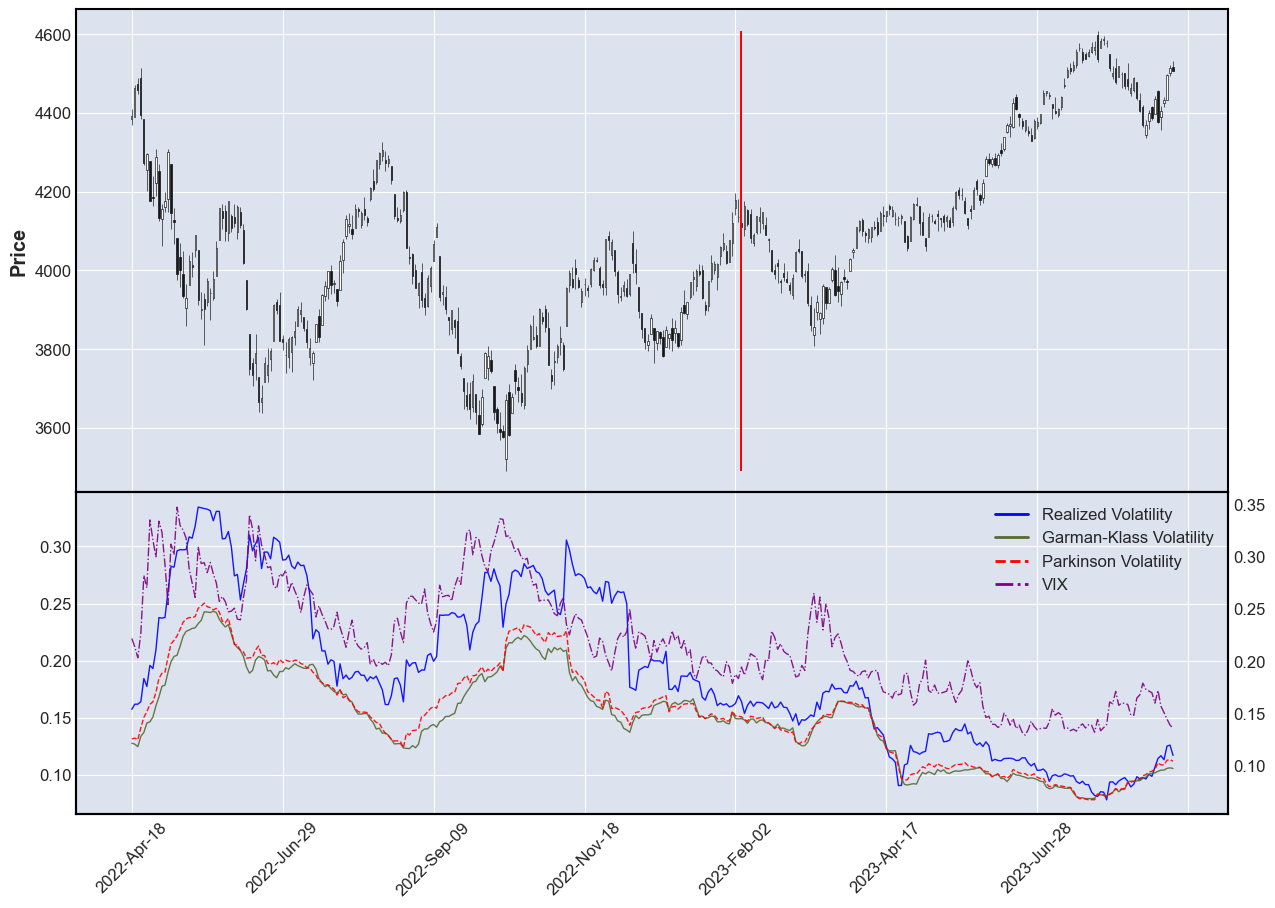

Index Data - Start date: 2023-02-06, End date: 2023-08-31 00:00:00


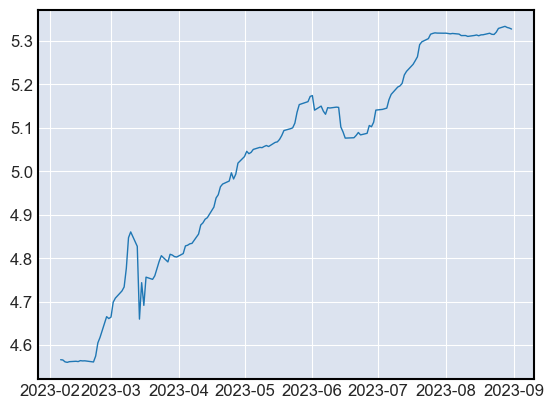

In [47]:
training_start_date = '2022-04-18'
training_cutoff_date = '2023-02-06'

try:
    os.chdir('dissertation')
except:
    print('could not find a directory named dissertation')

# Load VIX data
vix_data = pd.read_csv('vix.csv')
vix_data = vix_data.rename(columns={"Date": "date"})
vix_data['date'] = pd.to_datetime(vix_data['date'])
vix_data.set_index('date', inplace=True)
vix_data = vix_data.loc[training_start_date:] # Training start date

# Load SPX index data
index_price_data = pd.read_csv('spx_ndx_rut.csv')

spx_price = index_price_data[index_price_data['ticker'] == 'SPX'].copy()
spx_price['date'] = pd.to_datetime(spx_price['date'])
spx_price.set_index('date', inplace=True)
spx_price['realized_21period_vol'] = bsHelper.get_realized_vol(spx_price, 21)
spx_price['parkinson_21period_vol'] = bsHelper.get_historical_vol(spx_price, 'parkinson', 21)
spx_price['gk_21period_vol'] = bsHelper.get_historical_vol(spx_price, 'gk', 21)
spx_price = spx_price.loc['2022-04-18':] # Training start date
spx_price = pd.concat([spx_price, (vix_data['vix']/100)], axis=1, join="inner") # Add VIX data

def make_index_plot():
    apds = [
        mpf.make_addplot(spx_price['realized_21period_vol'], panel=1, color='blue', linestyle='-', width=1, alpha=0.9),
        mpf.make_addplot(spx_price['gk_21period_vol'], panel=1, color='darkolivegreen', linestyle='-', width=1, alpha=0.9),
        mpf.make_addplot(spx_price['parkinson_21period_vol'], panel=1, color='red', linestyle='--', width=1, alpha=0.9),
        mpf.make_addplot(spx_price['vix'], panel=1, color='purple', linestyle='-.', width=1, alpha=0.9)
    ]

    fig, axlist = mpf.plot(
        spx_price,
        addplot=apds,
        figscale=2,
        type='candle',
        vlines=dict(vlines=[training_cutoff_date], linewidths=0.2, colors='red'),
        returnfig=True,
        panel_ratios=(3, 2)
    )

    ax_volatility = axlist[2]
    legend_lines = [
        mlines.Line2D([], [], color='blue', linestyle='-', label='Realized Volatility'),
        mlines.Line2D([], [], color='darkolivegreen', linestyle='-', label='Garman-Klass Volatility'),
        mlines.Line2D([], [], color='red', linestyle='--', label='Parkinson Volatility'),
        mlines.Line2D([], [], color='purple', linestyle='-.', label='VIX'),
    ]

    ax_volatility.legend(handles=legend_lines, loc='upper right')
    fig.tight_layout()

    mpf.show()

make_index_plot()

# Load interest rates data
sofr = pd.read_csv('TSFR1and3M.csv')
sofr['Date'] = pd.to_datetime(sofr['Date'], dayfirst=True)
sofr.set_index('Date', inplace=True)
# start_date = spx_price.index.min()
start_date = training_cutoff_date
end_date = spx_price.index.max()
sofr = sofr[(sofr.index >= start_date) & (sofr.index <= end_date)]
print(f"Index Data - Start date: {start_date}, End date: {end_date}")

# Plot index rates
plt.plot(sofr.index, sofr.TSFR1M, linewidth=1)
plt.show()


In [102]:
# Split test and train
spx_train = spx_price.loc[:training_cutoff_date]
spx_test  = spx_price.loc[training_cutoff_date:]

# Generate a Q Matrix for realized 21 period volatility
volatility = spx_train['realized_21period_vol'].copy()
volatility.name = 'volatility'
vol_state_test_df = bsHelper.qcut_volatility(volatility, nStates=3)


In [88]:
# Simulate stock price using the ctmc
curdate = spx_test.iloc[1:2].index[0]
curdate_str = curdate.strftime('%Y-%m-%d')
expiry_date = '2023-02-17'
St = spx_price.loc[curdate_str].close

# Query options data to get the option prices at curdate for a given expiry date
query = """
    SELECT date, symbol, 
    best_bid, best_offer, ROUND((best_bid + best_offer)/2,2) AS mid_price, 
    (strike_price/1000) AS strike_price, cp_flag, exdate, ticker exercise_style 
    FROM ialun 
    WHERE ticker = 'SPX'
    AND date = '""" + curdate_str + """'
    AND exdate = '""" + expiry_date + """'
    AND cp_flag = 'C'
    AND strike_price BETWEEN """ + str((St - 100)*1000) + ' AND ' + str((St + 100)*1000) + """
    AND symbol NOT LIKE 'SPXW%';
    """
conn = sqlite3.connect('ialun_db.sqlite')
spx_options_data = pd.read_sql(query, conn)
conn.close()

strike_price = spx_options_data.iloc[4].strike_price
K = strike_price
r = sofr.loc[curdate_str].TSFR1M/100 # Converting interest to percentage
r = np.log(1 + r) # Continuously compounding rate
T = (pd.to_datetime(expiry_date) - curdate).days # time to expiry in days
t = 0

In [108]:
holding_times, transitions = bsHelper.getHoldingTimesAndTransitions(vol_state_test_df)
q_matrix = bsHelper.computeQMatrix(holding_times, transitions, vol_state_test_df)
# print(q_matrix)

# Create 1,000,000 sample paths for continuous-time markov chains generated using the q_matrix
nTrials = 1_000_000
generated_ctmc = bsHelper.simulate_ctmc_parallel(q_matrix, vol_state_test_df, start_state=0, time_horizon=T, num_simulations=nTrials, num_cores=5)

# Get the unique states and the corresponding volatility values from the generated ctmc
unique_states = bsHelper.get_unique_states(vol_state_test_df)

# Get an array of sigma values at one period corresponding to the generated ctmc
ctmc_sigmas = bsHelper.get_ctmc_sigmas(generated_ctmc, unique_states)

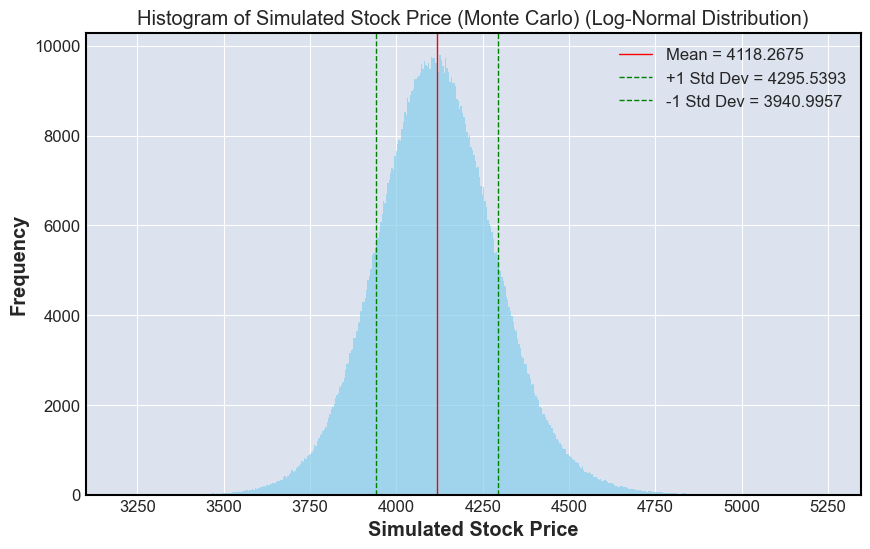



Strike Price = 4085, Interest Rate = 0.04464300515237069, Time to expiry (days) = 10, S0 = 4111.08
St_monte_carlo = 4118.2675, ST_actual = 4079.09


In [ ]:
# Obtain stock price at expiry using all the ctmc sigmas
def stock_price_monte_carlo(S0, mu, ctmc_sigmas, nTrials, time_to_expiry):
    Z_t = np.random.normal(0, 1, size=nTrials)
    # Sigma is ctmc_sigmas
    t = time_to_expiry/252
    exponential_term = np.exp((mu - 0.5 * ctmc_sigmas**2)*t + ctmc_sigmas*np.sqrt(t)*Z_t)
    St_monte_carlo = S0 * exponential_term
    
    return St_monte_carlo

mu = r
S0 = spx_price['close'].iloc[spx_price.index.get_loc(curdate) - 1]
St_monte_carlo = stock_price_monte_carlo(S0, mu, ctmc_sigmas, nTrials, T)
St_monte_carlo_mean = np.round(St_monte_carlo.mean(), 4)
St_monte_carlo_std = np.round(St_monte_carlo.std(), 4)

def plot_stock_price_simulation_histogram():
    plt.figure(figsize=(10, 6))
    plt.hist(St_monte_carlo, bins=500, color='skyblue', alpha=0.7)
    St_monte_carlo_labels = {
        'Mean': ('Mean = ' + str(St_monte_carlo_mean)),
        'upper_sd': ('+1 Std Dev = ' + str(np.round(St_monte_carlo_mean + St_monte_carlo_std, 4))),
        'lower_sd': ('-1 Std Dev = ' + str(np.round(St_monte_carlo_mean - St_monte_carlo_std, 4)))
    }
    plt.axvline(St_monte_carlo_mean, color='red', linestyle='-', linewidth=1, label=St_monte_carlo_labels['Mean'])
    plt.axvline(np.round(St_monte_carlo_mean + St_monte_carlo_std, 4), color='green', linestyle='--', linewidth=1, label=St_monte_carlo_labels['upper_sd'])
    plt.axvline(np.round(St_monte_carlo_mean - St_monte_carlo_std, 4), color='green', linestyle='--', linewidth=1, label=St_monte_carlo_labels['lower_sd'])
    plt.xlabel('Simulated Stock Price')
    plt.ylabel('Frequency')
    plt.title('Histogram of Simulated Stock Price (Monte Carlo) (Log-Normal Distribution)')
    plt.legend()
    plt.show()
    
plot_stock_price_simulation_histogram()

ST_actual = spx_price.loc[expiry_date].close

print(f'\n\nStrike Price = {K}, Interest Rate = {r}, Time to expiry (days) = {T}, S0 = {S0}')
print(f'St_monte_carlo = {St_monte_carlo_mean}, ST_actual = {ST_actual}')



In [134]:
# Calculate payoff using the simulated stock prices
def c_payoff(ST, K):
    return max(ST - K, 0)

call_option_prices = (np.vectorize(c_payoff))(St_monte_carlo, K)

In [142]:
average_payoff_at_expiry = np.mean(call_option_prices)

# Discount the average payoff back to today
# Make sure 't' here is the same 't' (in years) used in your stock_price_monte_carlo function
t_years = T / 252 # Use the same conversion as in your function

estimated_call_option_price = average_payoff_at_expiry * np.exp(-r * t_years)
print(call_option_prices.mean())
print(f'\nEstimated Call Option Price (Monte Carlo): {estimated_call_option_price:.4f}')

91.21070025485733

Estimated Call Option Price (Monte Carlo): 91.0493


In [137]:
call_option_prices.mean()

86.759592

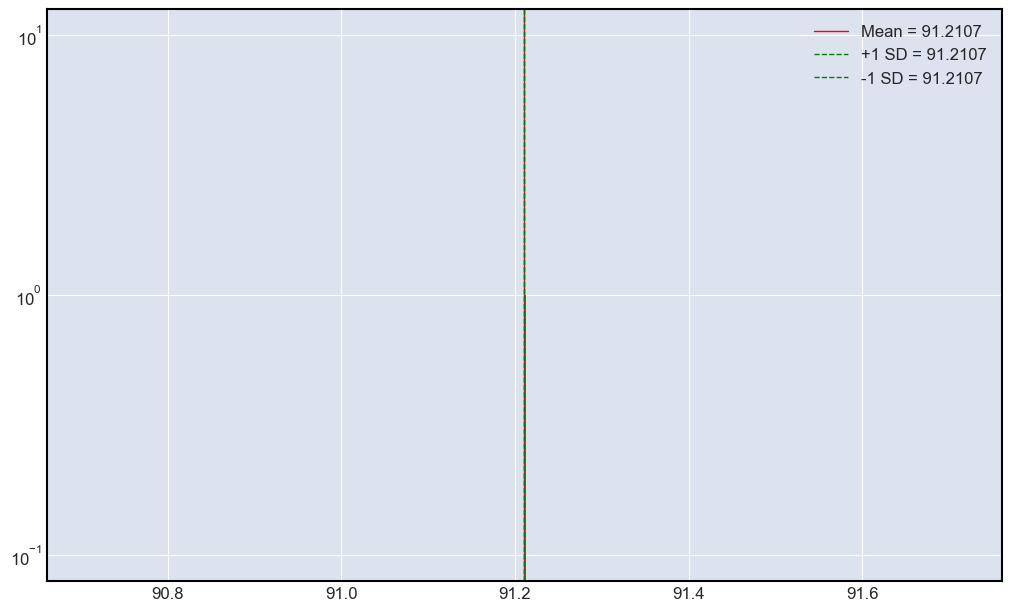

In [138]:
# Simulate call option prices using the monte carlo method
call_option_prices = bsHelper.black_scholes(St_monte_carlo.mean(), K, r, T, t, ctmc_sigmas.mean())
ct_simulated = call_option_prices.mean()
ct_simulated_std = call_option_prices.std()


def plot_call_option_price_histogram():
    fig, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(10, 6))
    plus_one_sd = np.round(ct_simulated + ct_simulated_std, 4)
    minus_one_sd = np.round(ct_simulated - ct_simulated_std, 4)
    
    ax1.hist(call_option_prices, bins=500)
    ax1.axvline(ct_simulated, color='r', linewidth=1, label=f'Mean = {np.round(ct_simulated, 4)}')
    ax1.axvline(plus_one_sd, linestyle='--', color='g', linewidth=1, label=f'+1 SD = {plus_one_sd}')
    ax1.axvline(minus_one_sd, linestyle='--', color='g', linewidth=1, label=f'-1 SD = {minus_one_sd}')
    ax1.set_yscale('log')
    ax1.legend()
    plt.show()

plot_call_option_price_histogram()

#%%

# St_actual = spx_price.loc[curdate].close

# print(f'\n\nStrike Price = {K}, Interest Rate = {r}, Time to expiry (days) = {T}, S0 = {S0}')
# print(f'St_monte_carlo = {St_monte_carlo_mean}, St_actual = {St_actual}')
# print(f'Call_option_price_monte_carlo = {call_option_prices_mean}')

# # Compute implied volatility from the simulated observed call option price
# K = strike_price
# T = (pd.to_datetime(expiry_date) - curdate).days
# t = 0
# cmtc_sigmas_mean = ctmc_sigmas.mean()
# iv_monte_carlo = bsHelper.newton_rhapson(St_monte_carlo_mean, K, r, T, t, cmtc_sigmas_mean, call_option_prices_mean, max_iterations=10000)

# print(f'cmtc_sigmas_mean = {cmtc_sigmas_mean}, iv_monte_carlo = {iv_monte_carlo}')

# %%


In [59]:
# ctmc_iv = bsHelper.newton_rhapson(St_actual, K, r, T, t, cmtc_sigmas_mean, , )
# iv_actual = bsHelper.newton_rhapson(St_actual, K, r, T, t, cmtc_sigmas_mean, 105.45, max_iterations=10000)
# iv_actual
print( bsHelper.black_scholes(St_actual, K, r*2, T, t, 0.20 ))

122.49965688683142


In [42]:
spx_price.loc[curdate]

secid                       108105
ticker                         SPX
index_flag                       1
low                        4088.39
high                       4176.54
open                       4105.35
close                       4164.0
volume                           0
cfadj                            1
cfret                            1
returns                    0.01279
realized_21period_vol     0.153604
parkinson_21period_vol    0.144149
gk_21period_vol           0.143698
vix                         0.1866
Name: 2023-02-07 00:00:00, dtype: object